## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [3]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


### 1.1 Fetch Data

In [4]:
# Define the local path to store the CSV files from the LabPC
local_results_folder = Path("./Nginx_Data")

# Create the folder if it does not already exist
local_results_folder.mkdir(parents=True, exist_ok=True)

print(f"Local results folder set to: {local_results_folder.resolve()}")



Local results folder set to: /home/glonex/Workspace/Interference/profiling/Nginx_Data


In [7]:
# Check if the folder exists and delete all files inside it

if local_results_folder.exists():
    for file in local_results_folder.iterdir():
        if file.is_file():
            file.unlink()
    print("All files in the folder have been deleted.")


All files in the folder have been deleted.


In [ ]:
# Replace 'george@147.102.13.77' and the remote path with your actual credentials and remote paths
remote_path = "george@147.102.13.77:/home/george/Workspace/Nginx_Metrics_V04/*"

# Use shell command to securely copy all CSV files from remote
!scp {remote_path} {str(local_results_folder)}/ 

# enter passphrase for the remote server


scp: /home/george/Workspace/Nginx_Metrics_V04/light_raw: not a regular file
scp: /home/george/Workspace/Nginx_Metrics_V04/medium_raw: not a regular file
pcm_core_metrics_light_baseline.csv           100% 6973   405.3KB/s   00:00    
pcm_core_metrics_light_cpu_1.csv              100% 7759   437.7KB/s   00:00    
pcm_core_metrics_light_cpu_2.csv              100% 6973   130.2KB/s   00:00    
pcm_core_metrics_light_cpu_4.csv              100% 7103   408.8KB/s   00:00    
pcm_core_metrics_light_l3_1.csv               100% 7029   426.6KB/s   00:00    
pcm_core_metrics_light_l3_2.csv               100% 7088   427.8KB/s   00:00    
pcm_core_metrics_light_l3_4.csv               100% 6977   344.2KB/s   00:00    
pcm_core_metrics_light_l3_8.csv               100% 6974   415.1KB/s   00:00    
pcm_core_metrics_light_membw_1.csv            100% 6973   430.0KB/s   00:00    
pcm_core_metrics_light_membw_2.csv            100% 7763   483.1KB/s   00:00    
pcm_core_metrics_light_membw_4.csv            1

In [5]:
# List all CSV files in the local_results_folder
csv_files = list(local_results_folder.glob("*.csv"))

if not csv_files:
    print("No CSV files found in the directory. Check SCP or paths.")
else:
    for f in csv_files:
        # Number of rows and columns in the CSV file
        num_rows = sum(1 for _ in open(f))
        num_cols = len(pd.read_csv(f, nrows=0).columns)
        print(f"File: {f.name}, Rows: {num_rows}, Columns: {num_cols}")


File: perf_metrics_light_membw_1.csv, Rows: 14, Columns: 19
File: pcm_core_metrics_medium_l3_1.csv, Rows: 22, Columns: 72
File: pcm_core_metrics_light_membw_1.csv, Rows: 14, Columns: 72
File: pcm_core_metrics_medium_l3_2.csv, Rows: 22, Columns: 72
File: perf_metrics_light_membw_4.csv, Rows: 14, Columns: 19
File: perf_metrics_medium_membw_2.csv, Rows: 22, Columns: 19
File: pcm_system_metrics_light_baseline.csv, Rows: 14, Columns: 14
File: perf_metrics_light_cpu_2.csv, Rows: 14, Columns: 19
File: perf_metrics_light_l3_8.csv, Rows: 14, Columns: 19
File: perf_metrics_light_membw_8.csv, Rows: 14, Columns: 19
File: pcm_system_metrics_medium_l3_1.csv, Rows: 22, Columns: 14
File: pcm_system_metrics_medium_cpu_1.csv, Rows: 22, Columns: 14
File: pcm_system_metrics_medium_l3_2.csv, Rows: 22, Columns: 14
File: pcm_system_metrics_light_membw_4.csv, Rows: 14, Columns: 14
File: perf_metrics_medium_membw_8.csv, Rows: 22, Columns: 19
File: pcm_core_metrics_medium_membw_2.csv, Rows: 22, Columns: 72
File

### 1.2 View Data

In [6]:
file_patterns = {
    "perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "workload": "*workload*.csv",
}

In [7]:
interference_snenarios = ["baseline", "cpu_1_pod", "cpu_2_pod", "cpu_4_pod", "cpu_8_pod", "l3_1_pod", "l3_2_pod", "l3_4_pod", "membw_1_pod", "membw_2_pod", "membw_4_pod", "membw_8_pod"]

#### Example of each data file

In [8]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: perf - File: perf_metrics_light_membw_1.csv ===


,time,task-clock,branches,branch-instructions,branch-misses,stalled-cycles-frontend,stalled-cycles-backend,bus-cycles,cache-references,cache-misses,LLC-loads,LLC-load-misses,LLC-stores,LLC-store-misses,cycle_activity.stalls_l3_miss,mem-loads,mem-stores,dtlb_load_misses.stlb_hit,page-faults
0,5.004788,NaN,10934297726,10939441222,75594823,NaN,NaN,580894975,888175352,250538033,63798320,4596470,117898244,74285718,1597986359,0,9786120310,385320726,28182
1,10.009803,NaN,20135861680,20118696965,166113240,NaN,NaN,1110099387,1317922097,273330051,142628578,4698521,252572590,140546441,1529716877,0,17330490901,977189883,3407
2,15.015792,NaN,18598517649,18600241083,155266915,NaN,NaN,1064762550,1262508384,281249699,143622844,4661833,300361703,188545610,1581502193,0,16012172644,874749870,1540
3,20.041789,NaN,20109947634,20117016427,167504972,NaN,NaN,1110522130,1321071788,269957357,143570016,4478449,246948292,135746549,1592251932,0,17406812045,979601615,3093
4,25.058796,NaN,20127555954,20150338924,168206584,NaN,NaN,1112760676,1346623480,271809686,146680676,4468670,251081275,137631829,1568656928,0,17345593334,966902751,2043




=== Category: pcm_system - File: pcm_system_metrics_light_baseline.csv ===


,System - Date,System - Time,System - IPC,System - L3MISS,System - L2MISS,System - READ,System - WRITE,System - PhysIPC,System - PhysIPC%,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,System Pack C-States - C0res%,System Pack C-States - C6res%
0,2025-05-16,16:18:03.471,0.97,0.14,3.56,2.17,0.49,1.94,38.73,1.85,80.43,0.0,96.46,0.13
1,2025-05-16,16:18:08.470,0.98,0.08,8.12,1.43,0.51,1.95,39.08,4.26,95.74,0.0,100.00,0.00
2,2025-05-16,16:18:13.471,0.98,0.09,8.10,1.50,0.50,1.96,39.16,4.26,95.74,0.0,100.00,0.00
3,2025-05-16,16:18:18.470,0.98,0.08,8.09,1.39,0.48,1.95,39.05,4.25,95.75,0.0,100.00,0.00
4,2025-05-16,16:18:23.470,0.98,0.09,8.22,1.49,0.51,1.95,39.01,4.26,95.74,0.0,100.00,0.00




=== Category: pcm_cores - File: pcm_core_metrics_medium_l3_1.csv ===


,System - Date,System - Time,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,SKT0 Core C-State - C0res%,SKT0 Core C-State - C1res%,SKT0 Core C-State - C6res%,Core0 (Socket 0) - IPC,Core0 (Socket 0) - L3MISS,...,Core6 (Socket 0) - PhysIPC,Core6 (Socket 0) - PhysIPC%,Core7 (Socket 0) - IPC,Core7 (Socket 0) - L3MISS,Core7 (Socket 0) - L2MISS,Core7 (Socket 0) - C0res%,Core7 (Socket 0) - C1res%,Core7 (Socket 0) - C6res%,Core7 (Socket 0) - PhysIPC,Core7 (Socket 0) - PhysIPC%
0,2025-05-17,17:53:48.853,2.85,82.62,0.0,2.85,82.62,0.0,0.83,0.20,...,1.68,33.54,0.83,0.21,10.94,2.70,84.07,0.0,1.65,33.03
1,2025-05-17,17:53:53.853,5.61,94.39,0.0,5.61,94.39,0.0,0.83,0.39,...,1.65,32.92,0.83,0.44,10.25,5.68,94.32,0.0,1.66,33.10
2,2025-05-17,17:53:58.851,5.62,94.38,0.0,5.62,94.38,0.0,0.83,0.38,...,1.69,33.76,0.83,0.48,10.38,5.74,94.26,0.0,1.66,33.10
3,2025-05-17,17:54:03.851,5.60,94.40,0.0,5.60,94.40,0.0,0.83,0.41,...,1.64,32.71,0.82,0.43,9.98,5.61,94.39,0.0,1.63,32.67
4,2025-05-17,17:54:08.853,5.61,94.39,0.0,5.61,94.39,0.0,0.84,0.41,...,1.64,32.76,0.84,0.32,9.51,5.64,94.36,0.0,1.69,33.79




=== Category: workload - File: workload_metrics.csv ===


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,light,baseline,2025-05-16,85601.55,317.94,291.0,317.0,498.0,638.0,NaN
1,light,cpu_1,2025-05-16,52611.49,714.42,451.0,514.0,960.0,5980.0,NaN
2,light,cpu_2,2025-05-16,47528.82,1140.00,470.0,832.0,2690.0,10430.0,NaN
3,light,cpu_4,2025-05-16,33693.92,3430.00,563.0,2610.0,11550.0,30010.0,NaN
4,light,l3_1,2025-05-16,76755.62,373.47,324.0,389.0,602.0,920.0,NaN


#### Columns in each data file

In [9]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: perf - File: perf_metrics_light_membw_1.csv ===
['time', 'task-clock', 'branches', 'branch-instructions', 'branch-misses', 'stalled-cycles-frontend', 'stalled-cycles-backend', 'bus-cycles', 'cache-references', 'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores', 'LLC-store-misses', 'cycle_activity.stalls_l3_miss', 'mem-loads', 'mem-stores', 'dtlb_load_misses.stlb_hit', 'page-faults']


=== Category: pcm_system - File: pcm_system_metrics_light_baseline.csv ===
['System - Date', 'System - Time', 'System - IPC', 'System - L3MISS', 'System - L2MISS', 'System - READ', 'System - WRITE', 'System - PhysIPC', 'System - PhysIPC%', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'System Pack C-States - C0res%', 'System Pack C-States - C6res%']


=== Category: pcm_cores - File: pcm_core_metrics_medium_l3_1.csv ===
['System - Date', 'System - Time', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Cor

### 1.3 Load Data into Dataframes

In [10]:
Data_Dir_HR = 'HR_Data'
Data_Dir_Nginx = 'Nginx_Data'
Data_Dir = Data_Dir_Nginx
#traffic = 'TC-VM-01'
Perfomance_File = os.path.join(Data_Dir, 'workload_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)
    print("Loaded performance metrics:")
    display(df_perf.head())
    print(df_perf.shape)
else:
    print(f"Performance file not found at {Perfomance_File}. Please verify path.")
    df_perf = pd.DataFrame()



Loaded performance metrics:


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,light,baseline,2025-05-16,85601.55,317.94,291.0,317.0,498.0,638.0,NaN
1,light,cpu_1,2025-05-16,52611.49,714.42,451.0,514.0,960.0,5980.0,NaN
2,light,cpu_2,2025-05-16,47528.82,1140.00,470.0,832.0,2690.0,10430.0,NaN
3,light,cpu_4,2025-05-16,33693.92,3430.00,563.0,2610.0,11550.0,30010.0,NaN
4,light,l3_1,2025-05-16,76755.62,373.47,324.0,389.0,602.0,920.0,NaN


(24, 10)


In [11]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

## 2. Perfomance

1) Normalized Throughput Performance (NTP)

   Definition:
     NTP = Measured_Throughput / Baseline_Throughput

   Parameters:
   - Measured_Throughput: The throughput of the workload under interference (e.g., "Throughput" field in the CSV for a given scenario).
   - Baseline_Throughput: The throughput of the workload under the baseline (no interference). Typically, this is the “Throughput” value from a row where "Interference" = "baseline".

   Interpretation:
   - NTP > 1  => Application throughput exceeded the baseline
   - NTP < 1  => Application throughput degraded relative to baseline
   - NTP = 1  => No observed change vs. baseline


2) Normalized Latency Performance (NLP)

   Definition:
     NLP = Measured_Latency / Baseline_Latency

   Parameters:
   - Measured_Latency: A latency statistic (e.g., "Avg_Latency", "P90_Latency", "P99_Latency") for the scenario under interference.
   - Baseline_Latency: The corresponding latency statistic from the baseline scenario (where "Interference" = "baseline").

   Interpretation:
   - NLP > 1  => Latency is higher (worse) than baseline
   - NLP < 1  => Latency is lower (better) than baseline
   - NLP = 1  => No change in latency vs. baseline

   Note:
   You may apply NLP to any latency metric: P50, P75, P90, P99, etc. Choose whichever best suits your SLA or QoS focus.


3) QoS Degradation

   Definition (as a % increase in latency):
     QoS Degradation(%) = ((Measured_Latency - Baseline_Latency) / Baseline_Latency) * 100

   Parameters:
   - Measured_Latency: The same “Avg_Latency” or tail latency (e.g., "P99_Latency") under interference.
   - Baseline_Latency: The same latency value in the baseline scenario.

   Interpretation:
   - A positive value indicates how many percentage points slower the application is compared to the baseline.
   - Example: If baseline latency is 100 ms, and measured latency is 150 ms, QoS Degradation = ((150 - 100) / 100) * 100 = 50%


4) SLA Violations

   Definition:
     SLA Violations measure how often a latency threshold (e.g., “P99_Latency < 200 ms”) is exceeded.

   Common Calculation Approach:
     - Choose a latency statistic relevant to your SLA (e.g., P90, P99, or Max_Latency).
     - Define an SLA threshold T (e.g., 200 ms for P99 latency).
     - Count how many runs (or samples) exceed that threshold.
       SLA_Violation_Rate = (Number_of_Samples_Exceeding_T / Total_Samples) * 100

   Parameters:
   - P99_Latency (or whichever percentile you track) from the CSV for each interference scenario.
   - A chosen threshold T that represents your SLA limit.

   Note:
   If you are measuring SLA on a per-request basis rather than per-scenario, you would track the percentage of requests whose latency exceeded T. For scenario-level data, you can say a “violation” occurs if P99_Latency > T in that test case.

-----
Summary of Usage:

- “Baseline_*” values are typically taken from rows where `Interference = "baseline"`.
- For each test case under interference (e.g., `cpu100`, `membw100`, etc.), compute:
  1. Normalized Throughput = Throughput / Baseline_Throughput
  2. Normalized Latency   = (e.g.) P99_Latency / Baseline_P99_Latency
  3. QoS Degradation(%)   = ((P99_Latency - Baseline_P99_Latency) / Baseline_P99_Latency) * 100
  4. SLA Violation Rate   = Percentage of test cases (or requests) exceeding a given SLA threshold T


In [12]:
import pandas as pd

# 1) Load the one‐row‐per‐scenario workload metrics
wl = pd.read_csv(os.path.join(local_results_folder, "workload_metrics.csv"))

# 2) Define the exact labels present in wl for each category
cpu_labels   = ["baseline", "cpu_1", "cpu_2", "cpu_4", "cpu_8"]
l3_labels    = ["baseline", "l3_1",    "l3_2",    "l3_4"]
membw_labels = ["baseline", "membw_1", "membw_2", "membw_4", "membw_8"]

# 3) Subset into three DataFrames
cpu_df   = wl[wl["Interference"].isin(cpu_labels)].copy()
l3_df    = wl[wl["Interference"].isin(l3_labels)].copy()
membw_df = wl[wl["Interference"].isin(membw_labels)].copy()

def pod_count(interf):
    if interf == "baseline":
        return 0
    if interf.startswith("cpu_"):
        return int(interf.split("_")[1])
    if interf.startswith("l3_"):
        return int(interf.split("_")[1])
    if interf.startswith("membw_"):
        return int(interf.split("_")[1])
    return None

for df in (cpu_df, l3_df, membw_df):
    df["pod_count"] = df["Interference"].apply(pod_count)

# 5) Inspect the resulting DataFrames
print(cpu_df.to_string(index=False), "\n")
print(l3_df.to_string(index=False), "\n")
print(membw_df.to_string(index=False), "\n")


TestCaseID Interference       Date  Throughput  Avg_Latency  P50_Latency  P75_Latency  P90_Latency  P99_Latency  Max_Latency  pod_count
     light     baseline 2025-05-16    85601.55       317.94        291.0        317.0        498.0        638.0          NaN          0
     light        cpu_1 2025-05-16    52611.49       714.42        451.0        514.0        960.0       5980.0          NaN          1
     light        cpu_2 2025-05-16    47528.82      1140.00        470.0        832.0       2690.0      10430.0          NaN          2
     light        cpu_4 2025-05-16    33693.92      3430.00        563.0       2610.0      11550.0      30010.0          NaN          4
    medium     baseline 2025-05-16   126240.01       540.81        398.0        675.0        950.0       2320.0          NaN          0
    medium        cpu_1 2025-05-16   104957.88       900.00        483.0        940.0       1870.0       7080.0          NaN          1
    medium        cpu_2 2025-05-17    90428.96  

### 2.1 Normalized Perfomance
**Formula:**  
$$
\mathrm{NormalizedPerf} \;=\; \frac{\mathrm{Perf}_{\text{baseline}}}{\mathrm{Perf}_{\text{interference}}}
$$

*(Perf = p90 latency, so lower is better)*

**Usage**  
- Compares “what fraction of baseline performance remains” under interference.  
- Ideal for benchmarking across heterogeneous workloads or hardware.  
- Plots easily on a uniform [0–1] scale where 1.0 means no impact.

**Why We Need It**  
- Provides a **relative**, unit‐free measure of interference impact.  
- Allows apples-to-apples comparison even when absolute latencies differ.  
- Highlights which co-locations preserve most of their performance.

In [13]:
import matplotlib.pyplot as plt

def plot_normalized_performance(wl, cpu_df, l3_df, membw_df):
    # 1) Compute baseline P90 latency per TestCaseID
    baseline_p90 = (wl[wl["Interference"] == "baseline"].set_index("TestCaseID")["P90_Latency"])

    print(baseline_p90.to_string(), "\n")

    # 2) Add norm_perf = baseline_P90 / this_row_P90 to each df
    for df in (cpu_df, l3_df, membw_df):
        print(df["TestCaseID"].unique())
        df["norm_perf"] = df["TestCaseID"].map(baseline_p90) / df["P90_Latency"]
    
    print(cpu_df.to_string(index=False), "\n")

    # 3) For each interference type, plot one figure with a line per TestCaseID
    for df, label in [
        (cpu_df,   "CPU"),
        (l3_df,    "L3"),
        (membw_df, "MemBW")
    ]:
        plt.figure()
        for tc in df["TestCaseID"].unique():
            sub = df[df["TestCaseID"] == tc].sort_values("pod_count")
            plt.plot(
                sub["pod_count"],
                sub["norm_perf"],
                marker="o",
                linestyle="-",
                label=tc
            )

        plt.title(f"{label} interference → Normalized P90_Latency")
        plt.xlabel(f"Number of {label}-stress pods")
        plt.ylabel("Normalized Performance\n(baseline P90 / P90)")
        plt.xticks(sorted(df["pod_count"].unique()))
        plt.ylim(0, None)
        plt.legend(title="TestCaseID")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


TestCaseID
light     498.0
medium    950.0 

['light' 'medium']
['light' 'medium']
['light' 'medium']
TestCaseID Interference       Date  Throughput  Avg_Latency  P50_Latency  P75_Latency  P90_Latency  P99_Latency  Max_Latency  pod_count  norm_perf
     light     baseline 2025-05-16    85601.55       317.94        291.0        317.0        498.0        638.0          NaN          0   1.000000
     light        cpu_1 2025-05-16    52611.49       714.42        451.0        514.0        960.0       5980.0          NaN          1   0.518750
     light        cpu_2 2025-05-16    47528.82      1140.00        470.0        832.0       2690.0      10430.0          NaN          2   0.185130
     light        cpu_4 2025-05-16    33693.92      3430.00        563.0       2610.0      11550.0      30010.0          NaN          4   0.043117
    medium     baseline 2025-05-16   126240.01       540.81        398.0        675.0        950.0       2320.0          NaN          0   1.000000
    medium      

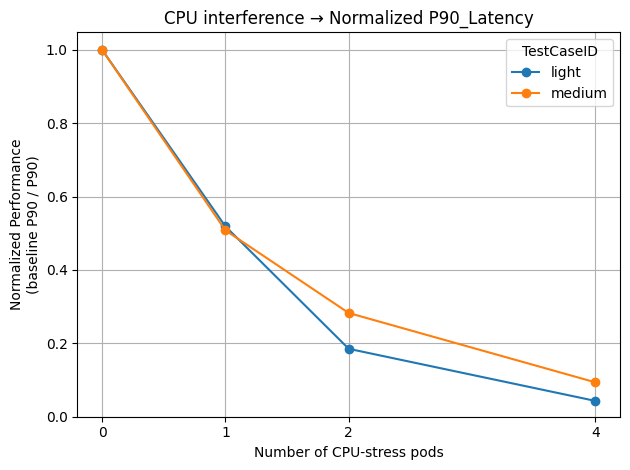

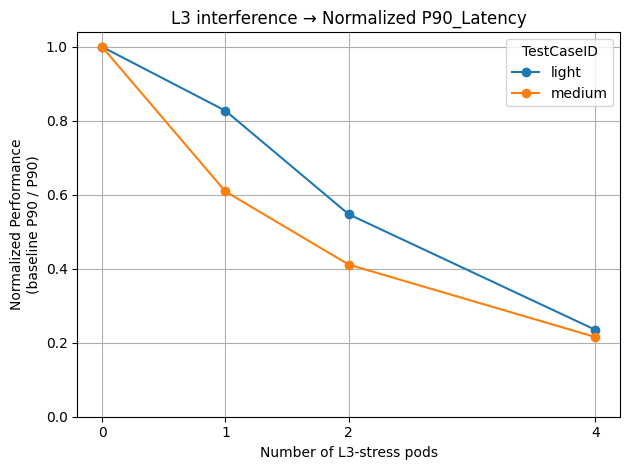

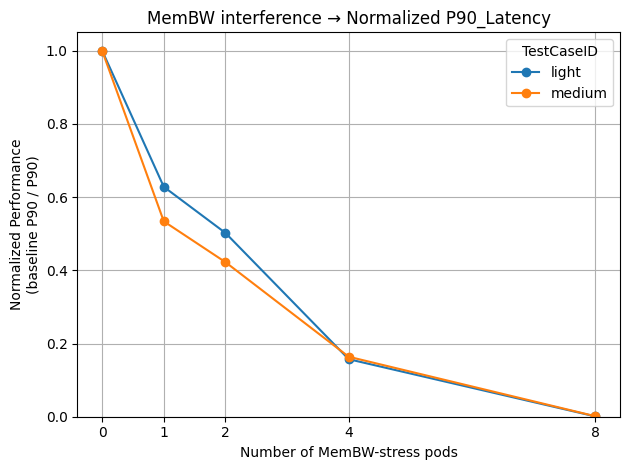

In [14]:
wl = pd.read_csv("Nginx_Data/workload_metrics.csv")
plot_normalized_performance(wl, cpu_df, l3_df, membw_df)

### 2.2 QoS Degradation
**Formula:**  
$$
\mathrm{QoS\_Degrad\%} \;=\; \frac{\mathrm{Perf}_{\text{with-intf}} \;-\; \mathrm{Perf}_{\text{alone}}}{\mathrm{Perf}_{\text{alone}}} \times 100\%
$$
**Usage**  
- Reports the **absolute** (or percentage) change in your QoS metric (e.g. +20 ms p90).  
- Ideal for capacity-planning (“each co-tenant adds this many milliseconds of tail latency”).

**Why We Need It**  
- Conveys the **magnitude** of slowdown in concrete units.  
- Helps operators budget additional latency and plan SLAs.

### 2.3 SLO Violation

**Formula:**  
$$
\mathrm{SLO\_ViolRate} \;=\; \frac{\bigl|\{\text{requests with latency} > \text{SLO\_threshold}\}\bigr|}{\text{total requests}}
$$

**Usage**  
- Measures the **fraction** (or count) of requests that breach your latency SLO.  
- Reported as a % or per-million rate, often over time or per scenario.

**Why We Need It**  
- Directly ties interference to user-visible failures or timeouts.  
- Captures threshold effects where small latency shifts cause large violation spikes.

### 2.4 Interference Sensitivity

**Formula**  
$$
\mathrm{Sensitivity} \;=\; \frac{\mathrm{Perf}_{\text{alone}} - \mathrm{Perf}_{\text{with-intf}}}{\mathrm{Perf}_{\text{alone}}}
\;=\; 1 \;-\; \mathrm{NormalizedPerf}
$$

**Usage**  
- Ranks workloads by **percent degradation** under interference.  
- Drives scheduler heuristics: e.g. “never co-locate two pods with > 30 % sensitivity.”  
- Plots as a single “pain score” per interference scenario.

**Why We Need It**  
- A concise score of how badly each service suffers.  
- Simplifies placement decisions by collapsing multiple metrics into one.  
- Highlights which pods need strongest isolation or resource guarantees.

##  3 Profiling: 

### **Given the state of the Server, what will the effect on the Application's Perfomance be?**

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.

**Why calculate p95?**

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.



In [15]:
def extract_pcm_features(data_dir, window_size=2, stats=('mean','p95','std')):
    """
    Extract PCM features from CSV logs, with optional sliding-window statistics.

    Parameters:
    - data_dir (str): Directory containing PCM CSV files.
    - traffic (str): Traffic identifier used in filename pattern.
    - window_size (int, optional): Number of samples for rolling window. If None, compute global stats only.
    - stats (tuple): Which statistics to compute. Options:
        'mean'  - average value (captures central tendency)
        'p95'   - 95th percentile (tail behavior indicator)
        'std'   - standard deviation (variability/burstiness)
        'max'   - maximum (peak events)
        'min'   - minimum (idle or trough behavior)
    Returns:
    - pd.DataFrame: One row per file, features + Interference label.
    """
    # Pattern to match PCM CSV files for given traffic
    pcm_pattern = os.path.join(data_dir, f'pcm_system_metrics_*.csv')
    pcm_files = glob.glob(pcm_pattern)

    if not pcm_files:
        print(f"⚠️ No PCM files found with pattern: {pcm_pattern}")
        return pd.DataFrame()

    feature_list = []
    for filepath in pcm_files:
        # Derive interference label from filename
        fname = os.path.basename(filepath)
        interference = fname.replace(f'pcm_system_metrics_', '').replace('.csv', '')

        # Load raw PCM data
        df_pcm = pd.read_csv(filepath)
        numeric_cols = df_pcm.select_dtypes(include=[np.number]).columns.tolist()

        # Drop unneeded counters
        drop_filters = ["System Pack C-States", "System - PhysIPC", "System - PhysIPC%"]
        numeric_cols = [c for c in numeric_cols if not any(x in c for x in drop_filters)]

        # Container for per-column features
        col_features = {}

        # Helper to compute windowed stats or global stats
        def compute_stats(series):
            """Compute statistics for a single series, with or without rolling window."""
            results = {}
            if window_size:
                # Rolling window object
                win = series.rolling(window=window_size, center=True, min_periods=1)
                # Global aggregation of windowed stats
                if 'mean' in stats:
                    results['mean'] = win.mean().mean()
                if 'std' in stats:
                    results['std'] = win.std().mean()
                if 'max' in stats:
                    results['max'] = win.max().mean()
                if 'min' in stats:
                    results['min'] = win.min().mean()
                if 'p95' in stats:
                    results['p95'] = win.quantile(0.95).mean()
            else:
                # Global stats only
                if 'mean' in stats:
                    results['mean'] = series.mean()
                if 'std' in stats:
                    results['std'] = series.std()
                if 'max' in stats:
                    results['max'] = series.max()
                if 'min' in stats:
                    results['min'] = series.min()
                if 'p95' in stats:
                    results['p95'] = series.quantile(0.95)
            return results

        # Compute features for each counter
        for col in numeric_cols:
            clean_name = clean_col(col)
            s = df_pcm[col]
            stats_dict = compute_stats(s)
            for stat_name, value in stats_dict.items():
                feature_key = f"{stat_name}_{clean_name}"
                col_features[feature_key] = value

        # Assemble into DataFrame row
        features = pd.DataFrame(col_features, index=[0])
        features['Interference'] = interference
        feature_list.append(features)

    # Concatenate all feature rows
    df_features = pd.concat(feature_list, ignore_index=True)

    # Debug prints
    #print(f"Extracted features from {len(feature_list)} files: {df_features.shape[1]-1} metrics + Interference label")
    #print(df_features.head())
    print("Columns:", df_features.columns.tolist())

    # Documentation of function usage
    # -----------------------------------------------------------------------------
    # This function reads raw PCM system metrics logs for a given traffic workload,
    # computes either global or sliding-window statistics for each hardware counter,
    # and returns a table where each row corresponds to one interference scenario.
    #
    # Sliding-window stats (mean, std, max, min, 95th percentile) capture temporal
    # burstiness and peaks that often drive tail-latency violations, which a single
    # average would miss. By allowing a configurable window size and stat set,
    # we can experiment to find the most predictive features for downstream risk
    # modeling.
    #
    # In the offline profiling pipeline, this extractor produces feature vectors
    # that are then joined with observed P99 latency to compute a RiskScore label
    # (Risk = P99_latency / SLO). These vectors feed into the learning pipeline
    # (Section 3.2–3.4) to train a non-linear predictor guiding interference-aware
    # scheduling decisions.
    # -----------------------------------------------------------------------------

    return df_features


In [16]:
df_features_HR = extract_pcm_features(Data_Dir)
display(df_features_HR)

Columns: ['mean_ipc', 'std_ipc', 'p95_ipc', 'mean_l3miss', 'std_l3miss', 'p95_l3miss', 'mean_l2miss', 'std_l2miss', 'p95_l2miss', 'mean_read', 'std_read', 'p95_read', 'mean_write', 'std_write', 'p95_write', 'mean_core_c_c0res%', 'std_core_c_c0res%', 'p95_core_c_c0res%', 'mean_core_c_c1res%', 'std_core_c_c1res%', 'p95_core_c_c1res%', 'mean_core_c_c6res%', 'std_core_c_c6res%', 'p95_core_c_c6res%', 'Interference']


,mean_ipc,std_ipc,p95_ipc,mean_l3miss,std_l3miss,p95_l3miss,mean_l2miss,std_l2miss,p95_l2miss,mean_read,...,mean_core_c_c0res%,std_core_c_c0res%,p95_core_c_c0res%,mean_core_c_c1res%,std_core_c_c1res%,p95_core_c_c1res%,mean_core_c_c6res%,std_core_c_c6res%,p95_core_c_c6res%,Interference
0,0.976923,0.003536,0.979000,0.096538,0.011196,0.103115,7.543846,0.493796,7.833923,1.573462,...,3.927692,0.243952,4.071000,93.583462,1.507905,94.469269,0.0,0.0,0.0,light_baseline
1,0.835952,0.002475,0.837452,3.038095,0.185969,3.150810,79.777143,1.324411,80.579857,10.415952,...,5.317619,0.173241,5.422619,93.402619,0.730088,93.845119,0.0,0.0,0.0,medium_l3_1
2,1.005000,0.006010,1.008643,0.150238,0.006718,0.154310,7.797857,0.540583,8.125500,2.052857,...,5.209286,0.171473,5.313214,93.431905,0.796909,93.914905,0.0,0.0,0.0,medium_cpu_1
3,0.670238,0.006010,0.673881,20.787381,1.127482,21.470738,119.485714,3.942827,121.875429,26.749762,...,8.199762,0.245012,8.348262,90.864762,0.439820,91.131333,0.0,0.0,0.0,medium_l3_2
4,0.642692,0.014731,0.651346,0.661154,0.035945,0.682269,4.369615,0.368285,4.585962,46.455000,...,6.016923,0.230988,6.152615,93.677308,0.462566,93.949038,0.0,0.0,0.0,light_membw_4
5,0.343810,0.004243,0.346381,0.652381,0.014142,0.660952,1.109524,0.030406,1.127952,44.218810,...,6.150476,0.014849,6.159476,93.849524,0.014849,93.858524,0.0,0.0,0.0,medium_membw_8
6,1.018333,0.016668,1.028233,0.364000,0.041416,0.388600,7.272667,0.744482,7.714867,44.549333,...,5.396000,0.335371,5.595200,93.260000,0.888934,93.788000,0.0,0.0,0.0,light_membw_2
7,1.067667,0.012627,1.075167,0.146333,0.031820,0.165233,6.411000,0.624779,6.782100,1.753667,...,4.396667,0.427295,4.650467,93.019333,2.109199,94.272133,0.0,0.0,0.0,light_cpu_1
8,0.676154,0.004714,0.678923,21.260385,0.761908,21.707962,132.103462,6.280876,135.793115,24.841154,...,7.784231,0.362392,7.997115,90.933077,0.662323,91.322154,0.0,0.0,0.0,light_l3_2
9,1.123810,0.012021,1.131095,0.274286,0.017678,0.285000,10.063333,0.578413,10.413905,1.575714,...,11.856667,0.226981,11.994238,88.041429,0.262337,88.200429,0.0,0.0,0.0,medium_cpu_4


### 3.2. Label Joining & Normalized Performance

**Objective:**  
Merge each hardware‐counter feature vector (`df_features`) with its corresponding observed tail‐latency, then convert raw latencies into a _normalized slowdown ratio_ that becomes our RiskScore target (`norm_perf`).

**Steps:**

1. **Extract per-traffic baseline latency and Compute slowdown ratio**  
    - For each `Interference` scenario, extract the baseline latency (e.g. P99) from the row where `Interference = "baseline"`.  
    - Compute the slowdown ratio:  
      ```python
      df_perf['Normalized_Performance'] = df_perf['P99_Latency'] / df_perf['Baseline_P99_Latency']
      ```
    - This gives us a measure of how much worse the latency is under interference compared to the baseline.

3. **Merge with features and set RiskScore**  
   - Inner‐join your feature table on the `Interference` column
   - The resulting `df_ml` contains one row per experiment, with:
     - all hardware‐counter summaries
     - the normalized target `norm_perf` (Risk < 1 ⇒ likely SLO violation)

**Why use norm_perf column?**  
- **Workload-agnostic target:** by normalizing against each test’s own baseline, the model doesn’t need to learn absolute latencies for every traffic pattern—only how much interference slows it down.  
- **Aligned with SLOs:** `norm_perf` becomes a direct proxy for “fraction of SLO consumed” (e.g. predicted P99 / SLO_ms), so a learned model can output a true RiskScore that the scheduler uses to decide placement or mitigation.


In [17]:
def calculate_norm_perf(df_perf, baseline_col='P90_Latency'):
    # Add a new column for normalized performance
    baseline_values = df_perf[df_perf['Interference'].str.contains('baseline')].set_index('TestCaseID')['P90_Latency']
    df_perf['norm_perf'] = df_perf['TestCaseID'].map(baseline_values) / df_perf[baseline_col]
    return df_perf

# Calculate normalized performance
df_perf = calculate_norm_perf(df_perf)

# Lets join the "TestCaseID" and "Interference" columns
df_perf['TestCaseID'] = df_perf['TestCaseID'].astype(str)
df_perf['Interference'] = df_perf['Interference'].astype(str)
df_perf['Interference'] = df_perf['TestCaseID'].str.cat(df_perf['Interference'], sep='_')
# Drop the original columns if needed
df_perf.drop(columns=['TestCaseID'], inplace=True)
display(df_perf.head(5))

,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,norm_perf
0,light_baseline,2025-05-16,85601.55,317.94,291.0,317.0,498.0,638.0,NaN,1.000000
1,light_cpu_1,2025-05-16,52611.49,714.42,451.0,514.0,960.0,5980.0,NaN,0.518750
2,light_cpu_2,2025-05-16,47528.82,1140.00,470.0,832.0,2690.0,10430.0,NaN,0.185130
3,light_cpu_4,2025-05-16,33693.92,3430.00,563.0,2610.0,11550.0,30010.0,NaN,0.043117
4,light_l3_1,2025-05-16,76755.62,373.47,324.0,389.0,602.0,920.0,NaN,0.827243


In [18]:
if not df_perf.empty and not df_features_HR.empty:
    df_ml = df_features_HR.merge(df_perf, on='Interference', how='inner')
    print("Combined ML-ready dataset:")
    display(df_ml)
else:
    df_ml = pd.DataFrame()
    print("⚠️ Cannot create ML dataset: missing performance or feature data.")

# Show columns of the final dataset
print("Final dataset columns:")
print(df_ml.columns.tolist())

Combined ML-ready dataset:


,mean_ipc,std_ipc,p95_ipc,mean_l3miss,std_l3miss,p95_l3miss,mean_l2miss,std_l2miss,p95_l2miss,mean_read,...,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,norm_perf
0,0.976923,0.003536,0.979000,0.096538,0.011196,0.103115,7.543846,0.493796,7.833923,1.573462,...,light_baseline,2025-05-16,85601.55,317.94,291.0,317.0,498.0,638.0,NaN,1.000000
1,0.835952,0.002475,0.837452,3.038095,0.185969,3.150810,79.777143,1.324411,80.579857,10.415952,...,medium_l3_1,2025-05-17,100208.12,771.80,558.0,1000.0,1560.0,3180.0,NaN,0.608974
2,1.005000,0.006010,1.008643,0.150238,0.006718,0.154310,7.797857,0.540583,8.125500,2.052857,...,medium_cpu_1,2025-05-16,104957.88,900.00,483.0,940.0,1870.0,7080.0,NaN,0.508021
3,0.670238,0.006010,0.673881,20.787381,1.127482,21.470738,119.485714,3.942827,121.875429,26.749762,...,medium_l3_2,2025-05-17,75405.24,1100.00,807.0,1500.0,2310.0,4340.0,NaN,0.411255
4,0.642692,0.014731,0.651346,0.661154,0.035945,0.682269,4.369615,0.368285,4.585962,46.455000,...,light_membw_4,2025-05-16,28994.50,1520.00,970.0,1890.0,3170.0,7530.0,NaN,0.157098
5,0.343810,0.004243,0.346381,0.652381,0.014142,0.660952,1.109524,0.030406,1.127952,44.218810,...,medium_membw_8,2025-05-17,644.89,231500.00,67600.0,339710.0,690130.0,1410000.0,NaN,0.001377
6,1.018333,0.016668,1.028233,0.364000,0.041416,0.388600,7.272667,0.744482,7.714867,44.549333,...,light_membw_2,2025-05-16,69391.52,467.59,355.0,551.0,992.0,1890.0,NaN,0.502016
7,1.067667,0.012627,1.075167,0.146333,0.031820,0.165233,6.411000,0.624779,6.782100,1.753667,...,light_cpu_1,2025-05-16,52611.49,714.42,451.0,514.0,960.0,5980.0,NaN,0.518750
8,0.676154,0.004714,0.678923,21.260385,0.761908,21.707962,132.103462,6.280876,135.793115,24.841154,...,light_l3_2,2025-05-16,62288.42,533.29,390.0,607.0,910.0,2510.0,NaN,0.547253
9,1.123810,0.012021,1.131095,0.274286,0.017678,0.285000,10.063333,0.578413,10.413905,1.575714,...,medium_cpu_4,2025-05-17,58925.67,3230.00,860.0,3090.0,10130.0,24990.0,NaN,0.093781


Final dataset columns:
['mean_ipc', 'std_ipc', 'p95_ipc', 'mean_l3miss', 'std_l3miss', 'p95_l3miss', 'mean_l2miss', 'std_l2miss', 'p95_l2miss', 'mean_read', 'std_read', 'p95_read', 'mean_write', 'std_write', 'p95_write', 'mean_core_c_c0res%', 'std_core_c_c0res%', 'p95_core_c_c0res%', 'mean_core_c_c1res%', 'std_core_c_c1res%', 'p95_core_c_c1res%', 'mean_core_c_c6res%', 'std_core_c_c6res%', 'p95_core_c_c6res%', 'Interference', 'Date', 'Throughput', 'Avg_Latency', 'P50_Latency', 'P75_Latency', 'P90_Latency', 'P99_Latency', 'Max_Latency', 'norm_perf']


### 3.3. Preprocessing & Pipeline Construction

**Objective:**  
Turn our raw hardware‐counter summaries into a compact, consistent input for a regressor that predicts the slowdown ratio (`Risk_obs`), while avoiding overfitting on just 24 experiments.

---

#### 1. Feature Selection  
- **Include all sliding-window stats:**  
  - `mean_`, `std_`, `p95_`  
- **Why?** These five measures per counter capture central tendency, variability, peaks, troughs, and tail‐behavior bursts—key signals for tail-latency.

#### 2. The Pipeline & Its Steps  
- **StandardScaler**: Normalize each feature to zero mean and unit variance.
- **PolynomialFeatures**: Expand the feature set with polynomial combinations of the original features.
- **PCA**: Reduce dimensionality while preserving variance.
- **RandomForestRegressor**: Train a regression model to predict the slowdown ratio.


In [19]:
from sklearn.decomposition import PCA

# 1. Identify feature columns and target
stat_prefixes = ('mean_', 'std_', 'p95_')
feature_cols = [c for c in df_ml.columns if c.startswith(stat_prefixes)]
X = df_ml[feature_cols]
y = df_ml['norm_perf']

# 2. Build a simple pipeline with PCA for dimensionality reduction
model_pipeline = Pipeline([
    # a) Normalize against baseline statistics
    ('scaler', StandardScaler()),
    # b) Add squared & interaction terms
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    # c) Compress the 324 features down to 20 composite components
    ('pca', PCA(n_components=20, random_state=42)),
    # d) Fit a Random Forest to predict the slowdown ratio
    ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 3. Fit the pipeline end-to-end
model_pipeline.fit(X, y)

# 4. (Optional) Inspect explained variance of the components
explained = model_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
print(f"Retained {explained:.1%} of variance in 20 components")

Retained 99.9% of variance in 20 components


### 3.4 Model Training & Evaluation

**Objective:**  
Assess how well our pipeline predicts the normalized slowdown (`norm_perf`) on interference scenarios it hasn’t seen, and quantify the expected error.

1. **Cross-Validation Strategy**  
   - We use **Leave-One-Interference-Level-Out** (LeaveOneGroupOut) CV, grouping by the `Interference` label.  
   - Each fold trains on all but one interference intensity (e.g. CPU×2, MemBW×4, etc.) and tests on the held-out level—mimicking how we need to generalize to new contention patterns.

2. **Scoring Metrics**  
   - **Mean Squared Error (MSE):** penalizes large deviations heavily; tells us how far off our predicted slowdown is, on average, in squared units.  
   - **Mean Absolute Error (MAE):** more interpretable “on average we’re ±X% off” in the slowdown ratio.

3. **Interpreting Results**  
   - A low MAE (e.g. 0.05) means we predict that a node’s tail latency will be within 5% of its true slowdown.  
   - These errors guide confidence in scheduling decisions: if the predicted slowdown differences between two nodes exceed our MAE, we can reliably pick the best node.

4. **Scheduler Integration**  
   - At runtime, the scheduler will load this **trained pipeline**, sample live hardware counters on each node, and compute `predicted_norm_perf`.  
   - It then assigns new pods to the node with the lowest predicted slowdown, or triggers mitigation if all nodes exceed an acceptable threshold.

By successfully completing this subsection, we’ll have a validated, quantifiable predictor of interference-induced slowdowns—our RiskScore—that the scheduler can trust for placement decisions.  


In [20]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

# Features & target (re-using names)
stat_prefixes = ('mean_', 'std_', 'max_', 'min_', 'p95_')
X = df_ml[[c for c in df_ml.columns if c.startswith(stat_prefixes)]]
y = df_ml['norm_perf']   # same as norm_perf

# Group by interference level so each fold leaves one stressor out
groups = df_ml['Interference']

# Define CV splitter
logo = LeaveOneGroupOut()

# Define scorers
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error)
}

# Perform cross-validation
cv_results = cross_validate(
    model_pipeline, X, y,
    cv=logo.split(X, y, groups=groups),
    scoring=scoring,
    return_train_score=False
)

# Summarize results
print("CV Mean Squared Error (per fold):", cv_results['test_MSE'])
print("Average MSE:", cv_results['test_MSE'].mean())
print("CV Mean Absolute Error (per fold):", cv_results['test_MAE'])
print("Average MAE:", cv_results['test_MAE'].mean())


CV Mean Squared Error (per fold): [0.31086475 0.01384281 0.16603243 0.20378026 0.11213462 0.00093135
 0.00164839 0.05124742 0.04245918 0.00883329 0.01199897 0.1100331
 0.21114591 0.00960423 0.00330176 0.0788452  0.043676   0.01276261
 0.13255298 0.03328892 0.045135   0.00158657 0.05191434 0.06130997]
Average MSE: 0.07162208690852946
CV Mean Absolute Error (per fold): [0.55755246 0.11765547 0.40747077 0.45142027 0.33486508 0.03051807
 0.04060035 0.22637893 0.20605627 0.09398559 0.10953983 0.33171237
 0.45950616 0.09800118 0.0574609  0.28079387 0.20898805 0.11297171
 0.36407826 0.18245253 0.21245    0.03983179 0.22784718 0.24760851]
Average MAE: 0.22498940041427232


### 3.5 Testing the Predictor on Real Data

**Goal:** Given a fresh PCM trace, forecast its slowdown and compare it against the single observed P90 latency.

1. **Feature Extraction**  
   - We call `extract_pcm_features(...)` on the `HR_Test` folder to compute the same sliding-window stats used during training.

2. **Prediction**  
   - We pass those stats into `model_pipeline.predict(...)` and capture `predicted_Risk`, our model’s estimate of slowdown (e.g., 5× slower than baseline).

3. **Observe True P90**  
   - We read the lone `P90_Latency` value from `workload_metrics.csv` (e.g., 46970 ms).

4. **Baseline Reference**  
   - We fetch the original baseline P90 (9430 ms) from our training DataFrame (`df_perf`), without relying on labels in the test CSV.

5. **Compute Actual Slowdown**  
   - `actual_Risk = observed_p90 / baseline_p90` (e.g., 46970 / 9430 ≈ 4.98).

6. **Comparison**  
   - Present a simple table showing `predicted_Risk` vs. `actual_Risk`.  
   - Close agreement validates that our offline-trained pipeline delivers reliable slowdown estimates for scheduler decision-making.


In [21]:
import os
import pandas as pd

# --- 1. Extract PCM features for the test run ---
test_dir   = "Nginx_Test"
traffic_id = "light-test_cpu_1_l3_1"      # matches the suffix in pcm_system_metrics_TC-VM-01_test.csv
window_size = 5              # same window size used during training
stats       = ('mean','std','p95')

df_test_feat = extract_pcm_features(
    data_dir=test_dir
)

# --- 2. Predict slowdown ratio with the trained pipeline ---
feature_cols = [c for c in df_test_feat.columns if c.startswith(('mean_','std_','p95_'))]
X_test        = df_test_feat[feature_cols]
predicted_risk = model_pipeline.predict(X_test)[0]

# --- 3. Load the observed P90 latency for this test run ---
df_workload = pd.read_csv(os.path.join(test_dir, "workload_metrics.csv"))
observed_p90 = df_workload["P90_Latency"].iloc[0]    # e.g. 46970.0 ms

# --- 4. Look up the baseline P90 latency from the training data (df_perf) ---
baseline_p90 = 638.0 ## Medium Traffic - Baseline P90 Latency

# --- 5. Compute the actual slowdown ratio ---
actual_risk = baseline_p90 / observed_p90

# --- 6. Display predicted vs. actual slowdown ---
error_percent = 100 * abs(predicted_risk - actual_risk) / actual_risk

result = pd.DataFrame({
    "predicted_Risk": [predicted_risk],
    "actual_Risk":    [actual_risk],
    "error_percent":  [error_percent]
})
print("Predicted vs. Actual Slowdown Ratios:")
display(result)


Columns: ['mean_ipc', 'std_ipc', 'p95_ipc', 'mean_l3miss', 'std_l3miss', 'p95_l3miss', 'mean_l2miss', 'std_l2miss', 'p95_l2miss', 'mean_read', 'std_read', 'p95_read', 'mean_write', 'std_write', 'p95_write', 'mean_core_c_c0res%', 'std_core_c_c0res%', 'p95_core_c_c0res%', 'mean_core_c_c1res%', 'std_core_c_c1res%', 'p95_core_c_c1res%', 'mean_core_c_c6res%', 'std_core_c_c6res%', 'p95_core_c_c6res%', 'Interference']
Predicted vs. Actual Slowdown Ratios:


,predicted_Risk,actual_Risk,error_percent
0,0.527923,0.425333,24.11985


## 4. Exporting the Predictor

In [22]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [23]:
# 1. Export the model pipeline and feature information
def export_predictor(df_ml, model_pipeline, feature_cols, filename='slowdown_predictor'):
    """
    Exports the complete predictor pipeline with all required metadata
    
    Args:
        df_ml: Your training DataFrame
        model_pipeline: The trained pipeline
        feature_cols: List of feature columns used
        filename: Base filename for exports
    """
    # Create export package
    export_data = {
        'model': model_pipeline,
        'feature_columns': feature_cols,
        'stat_prefixes': ('mean_', 'std_', 'p95_'),
        'input_requirements': {
            'required_features': feature_cols,
            'expected_ranges': {
                col: (df_ml[col].min(), df_ml[col].max())
                for col in feature_cols
            }
        },
        'pca_components': {
            'n_components': model_pipeline.named_steps['pca'].n_components,
            'explained_variance': model_pipeline.named_steps['pca'].explained_variance_ratio_,
            'total_variance': model_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
        },
        'model_metadata': {
            'type': 'RandomForestRegressor',
            'n_estimators': model_pipeline.named_steps['reg'].n_estimators,
            'features_count': len(feature_cols),
            'polynomial_degree': model_pipeline.named_steps['poly'].degree
        }
    }
    
    # Save the complete package
    joblib.dump(export_data, f'{filename}_full.pkl')
    
    # Save lightweight version for production (just model + features)
    joblib.dump({
        'model': model_pipeline,
        'feature_columns': feature_cols
    }, f'{filename}_lite.pkl')
    
    print(f"Exported predictor to {filename}_full.pkl and {filename}_lite.pkl")
    print(f"PCA retains {export_data['pca_components']['total_variance']:.1%} of variance")

# 2. Add this to your notebook after model training
# Assuming you have:
# - df_ml: Your training DataFrame
# - model_pipeline: Your trained pipeline
# - feature_cols: List of feature columns used

export_predictor(
    df_ml=df_ml,
    model_pipeline=model_pipeline,
    feature_cols=feature_cols,
    filename='slowdown_predictor'
)


Exported predictor to slowdown_predictor_full.pkl and slowdown_predictor_lite.pkl
PCA retains 99.9% of variance


In [24]:
# 3. Verify the export (optional)
def load_predictor(filename='slowdown_predictor_lite.pkl'):
    """Helper function to verify the export"""
    data = joblib.load(filename)
    print("Loaded predictor with:")
    print(f"- {len(data['feature_columns'])} feature columns")
    print(f"- Model type: {type(data['model']).__name__}")
    return data

# Test loading
test_load = load_predictor()

Loaded predictor with:
- 24 feature columns
- Model type: Pipeline
